# Analyzing NYC High School Data

The objective of the project is to explore the relationships between SAT scores and demographic factors in New York City public schools.

The SAT (Scholastic Aptitude Test), is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

We are going to use the following datasets in this project:
- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

We are going to include the `survey` datasets into our main dictionary.

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

We are going to add the `DBN` column in `hs_directory` to prepare the dataset for merging later.

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

We are going to convert some columns into numeric values for later aggregation of data.

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

We are going to convert AP scores to numeric values for aggregation later.

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

We are going to combine the cleaned datasets to prepare for our analysis.

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

We will add a `school district` column for easy aggregation of data.

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

After cleaning our `combined` dataset, let's explore the correlations between all the columns.

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

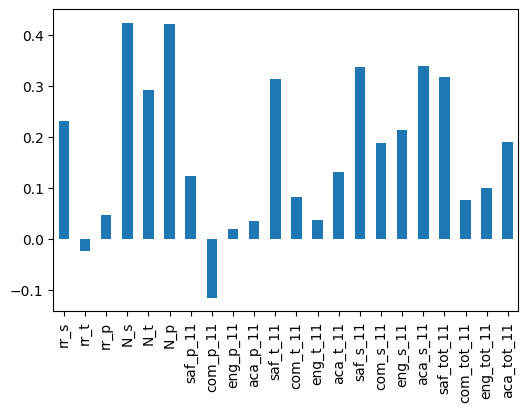

In [12]:
# Correlations between sat_score and survey_fields
import matplotlib.pyplot as plt
%matplotlib inline

combined.corr()["sat_score"][survey_fields].plot.bar()

By looking at the correlations between survey of parents, teachers and students and `sat_score`, we find the following interesting observations.

There is positive correlation between the number of respondents (fields: `N_s`, `N_t` and `N_p` and SAT scores.

There is positive correlation between the safety scores submitted by teachers and students (fields: `saf_t_11`, `saf_s_11`) and SAT scores. However, this correlation does not show in the case of parents' rating of safety score.

There is also positive correlation between the academic expectation score submitted by students (field: `aca_s_11`) and SAT scores, whereas this correlation does not show in the case of teacher's or parent's rating.

From the observations above, saftey perception seems to an interesting area to investigate further because it does not seem to have direct relationship with academic results.

# Safety and SAT Scores

We are going to explore the observation above by looking into schools that have low safety scores.

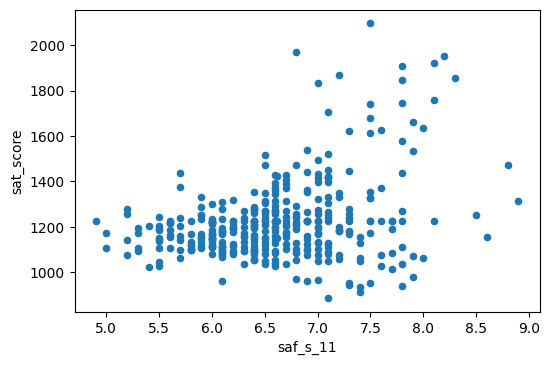

In [13]:
# Plot the correlation between saf_s_11 vs sat_score
combined.plot(x='saf_s_11', y='sat_score', kind='scatter')
plt.show()

In [14]:
# Compute safety scores for each borough
boros = combined.groupby('boro')['saf_s_11'].mean()
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


In general, the perceived safety scores are ranged ~5.5-7.5 among students, which are quite similar compared to the average perceived safety scores by borough.

Although Manhattan and Queens seem to have higher average perceived safety score by students, it does not seem to suggest any interesting correlations between perceived safety scores by students (`saf_s_11`) and SAT scores.

# Race and SAT Scores

Another interesting angle to investigate is race.

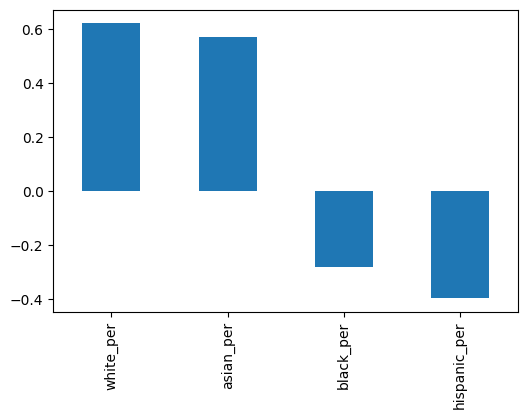

In [15]:
# Plot correlations between race columns and sat_score
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race_cols].plot.bar()
plt.show()

Some interesting observations are found from the plot above.

There is a high positive correlation between percentage of white students (field:`white_per`) and asian students (field:`asian_per`) and SAT score.

There is a negative correlation between percentage of hispanic students (field: `hispanic_per`) and SAT score.

We are going to take a deeper look into relationship between percentage of hispanic students and SAT score.

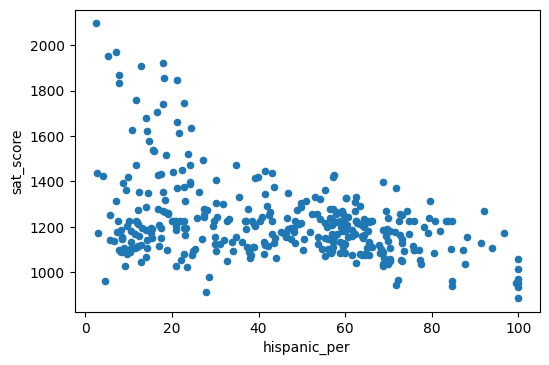

In [16]:
# Plot scatter diagram between hispanic_per and sat_score
combined.plot(x='hispanic_per', y='sat_score', kind='scatter')
plt.show()

From the scatter plot above, it shows a clear negative correlations pattern between percentage of hispanic students in a school and the SAT performance. SAT scores seem to be higher when there is a low percentage of hispanic students in a school.

In [17]:
# Filter the schools that have a high hispanic_per (>95%)
combined['SCHOOL NAME'][combined['hispanic_per'] > 95]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [18]:
# Filter the schools that have a low hispanic_per (<10%) and high sat_score (>1800)
combined['SCHOOL NAME'][(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

By looking into schools that have a high and low percentages of hispanic students repsectively, we find some interesting patterns.

In general, schools that have a high percentage of hispanic students (`hispanic_per` > 95%) seem to put more emphasis in language learning, multiculture and art, which are perceivably less academic focus. They also seem to have higher percentage of immigrants.

Meanwhile, schools that have a low percentage of hispanic students (`hispanic_per` < 10%) and obtain higher SAT scores seem to be focusing more on technology and science, which are perceivably more academically focused subjects.

# Gender and SAT Scores

Gender could also be another interesting angle to investigate in this topic. There are two fields that we can look deeper into: `male_per` and `female_per`.

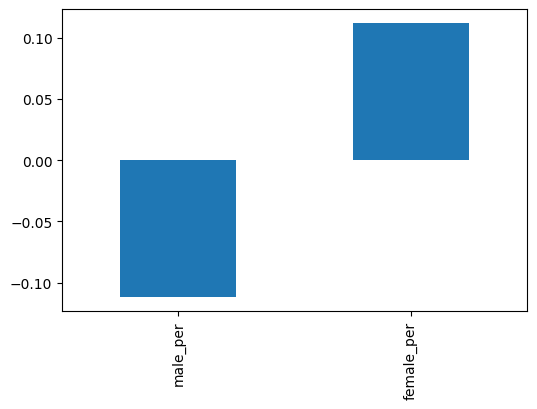

In [19]:
# Plot correlations between genders and sat_score
gender_cols = ['male_per', 'female_per']

combined.corr()['sat_score'][gender_cols].plot.bar()
plt.show()

The result above do not show a strong correlation between genders and SAT performance.

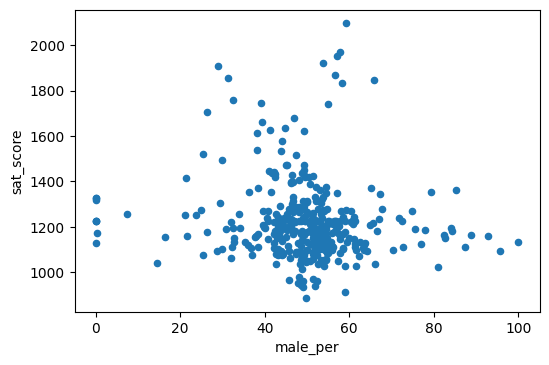

In [20]:
# Plot correlationship between male_per and sat_score
combined.plot(x='male_per', y='sat_score', kind='scatter')
plt.show()

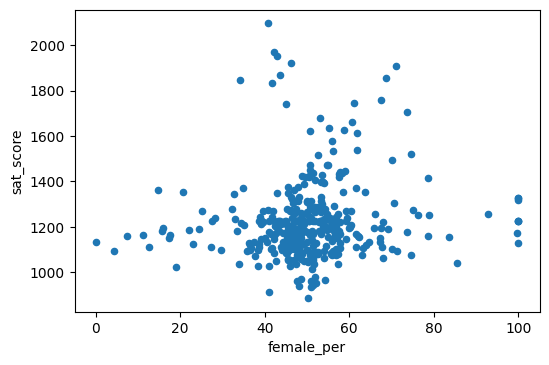

In [21]:
# Plot correlationship between female_per and sat_score
combined.plot(x='female_per', y='sat_score', kind='scatter')
plt.show()

By comparing the above two scatter plots, one interesting cluster to look at is when the schools have percentage of female stuents of 60-80%. These schools seem to perform better in SAT exams.

In [22]:
# Filter schools within the cluster of female_per > 60% and sat_score > 1700
combined['SCHOOL NAME'][(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

By looking into these schools, they seem to have a higher academic standard suggested by the higher difficulty of admission.

# AP Scores and SAT Scores

High school students also take Advanced Placement (AP) exams to earn college credit. We are going to explore the relationship between AP scores and SAT scores.

Before we start, since total enrollment (field: `total_enrollment`) in AP scores might potentially affect the findings of this relationship, we will only be looking at the percentage of students in each school who took at least one AP exam.

In [23]:
# Calculate the percentage of students who took at least one AP exam
combined['ap_per'] = combined['total_enrollment'] / combined['AP Test Takers ']

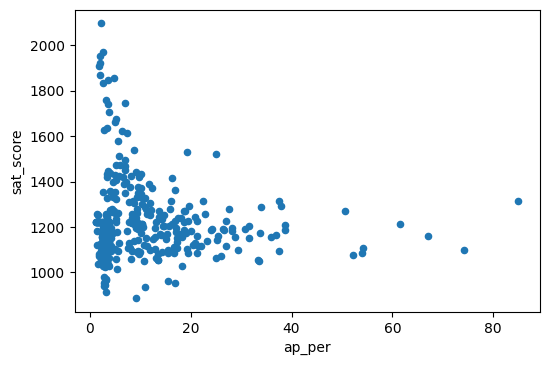

In [24]:
# Plot the correlation between ap_per and sat_score
combined.plot(x='ap_per', y='sat_score', kind='scatter')
plt.show()

In general, the plot shows a negative correlation between the percentage of students who took an AP exam and SAT scores. The correlation is not very strong.

It is interesting to see that the higher the percentage of students who took an AP exam, it does not necessary show higher SAT performance.

It looks like there could be interesting finding at the cluster when the percentage of students who took an AP exam is low (between 0-20%). Both highest and lowest SAT scores lay within this cluster.

# Class Size and SAT Scores

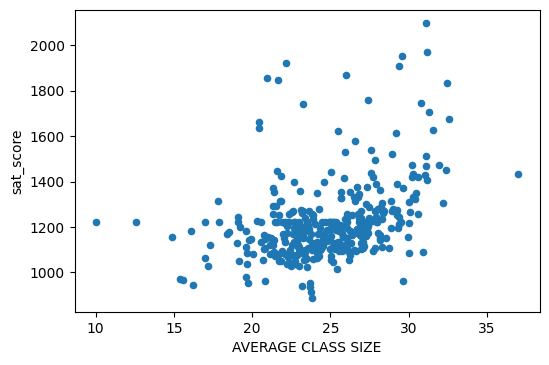

In [27]:
# Plot correlationship between class size and sat_score
combined.plot(x='AVERAGE CLASS SIZE', y='sat_score', kind='scatter')
plt.show()

In [32]:
# Filter schools with 20-30 students per class and sat_score > 1800
combined['SCHOOL NAME'][(combined['AVERAGE CLASS SIZE']>20) 
                        & (combined['AVERAGE CLASS SIZE']<30)
                        & (combined['sat_score']>1800)]

5                         BARD HIGH SCHOOL EARLY COLLEGE
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From the plot above, it does not show a clear correlation pattern between the average class size and SAT scores.

The majority of the schools have an average class size of 20-30 students, while filtering the schools that have higher SAT score in this cluster, these are mostly the same schools that focus on science and technology from the analysis in earlier sections.

# Neighbourhoods and SAT scores

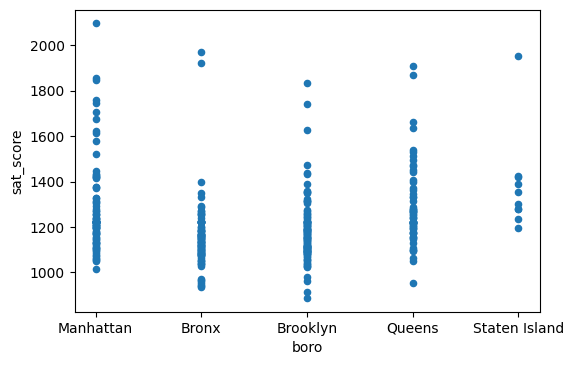

In [33]:
# Plot the correlations between neighbourhoods and sat scores
combined.plot(x='boro', y='sat_score', kind='scatter')
plt.show()

We can see some interesting patterns in the plot above.
In general, Manhattan and Queens seem to have schools with higher quality, while Bronx and Saten Island have a few distinct schools in the neighbourhood.

In [35]:
# Filter schools that have high sat score in Bronx
combined['SCHOOL NAME'][(combined['boro']=='Bronx') & (combined['sat_score']>1800)]

151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
Name: SCHOOL NAME, dtype: object

Both schools in Bronx are located at the northwest part of Bronx.

In [36]:
# Filter schools that have high sat score in Staten Island
combined['SCHOOL NAME'][(combined['boro']=='Staten Island') & (combined['sat_score']>1800)]

356    STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

By researching into the school, Staten Island Technical High School is ranked #2 in New York State as well as #13 in the nation (Source: [Wikipedia](https://en.wikipedia.org/wiki/Staten_Island_Technical_High_School)).

# Summary

From our analysis, we discover certain demographic factors are correlated to SAT performance of the schools.
- __High percentage of hispanic students at school:__ Higher percentage of hispanic students usually reflect that the schools contain higher percentage of immigrants, where these schools tend to focus more on language learning and other cultural adaptation programs for their students. In general, schools that contain high percentage of hispanic students tend to have lower SAT scores.
-__High percentage of female students at school:__Schools that contain higher percentage of female students tend to be very liberal art schools that have high academic standard for admission. These schools tend to perform better in SAT exam.

It seems that these demographic factors are correlated to SAT performance because of the admission of the schools. Schools that are located in more expensive neighbourhoods such as Manhattan and Queens tend to have lower percentage of immigrants, which suggest that these students could have higher living quality and additional support from family for their studies. It is also possible that the admission conditions of these schools have already pre-selected the better performaed students, in which we could see in the case of the art schools.